In [ ]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, precision_recall_curve, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Q1:

Load training data:

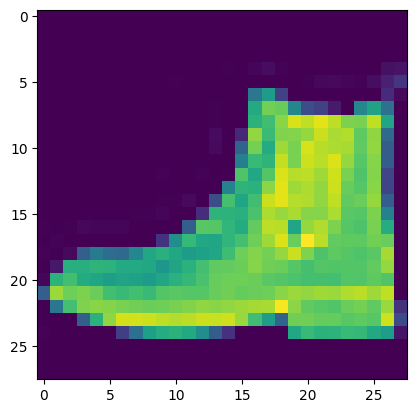

In [2]:
xtrain = np.loadtxt('Xtrain.csv')
ytrain = np.loadtxt('Ytrain.csv')
xtest =  np.loadtxt('Xtest.csv')

ximage = xtrain.reshape(3000, 28, 28)
num = np.random.randint(0,3000)

plt.imshow(ximage[num])
plt.show()


1.i.a:

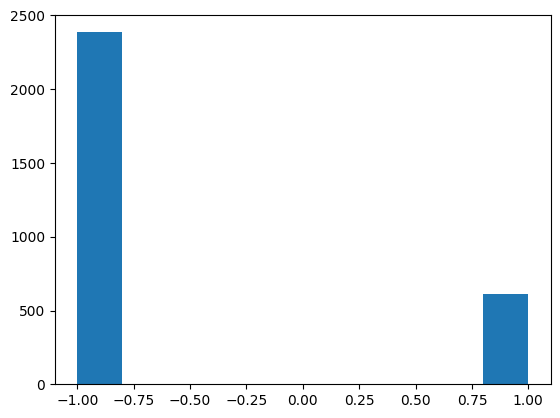

In [3]:
plt.hist(ytrain)
plt.show()

1.i.b: Because there are many more of class $-1$ than class $1$, the training data will give us a class imbalance. This can cause the model to favour predicting $-1$ as it is trying to minimize loss, and can cause incorrect predictions for unseen data with class $1$.

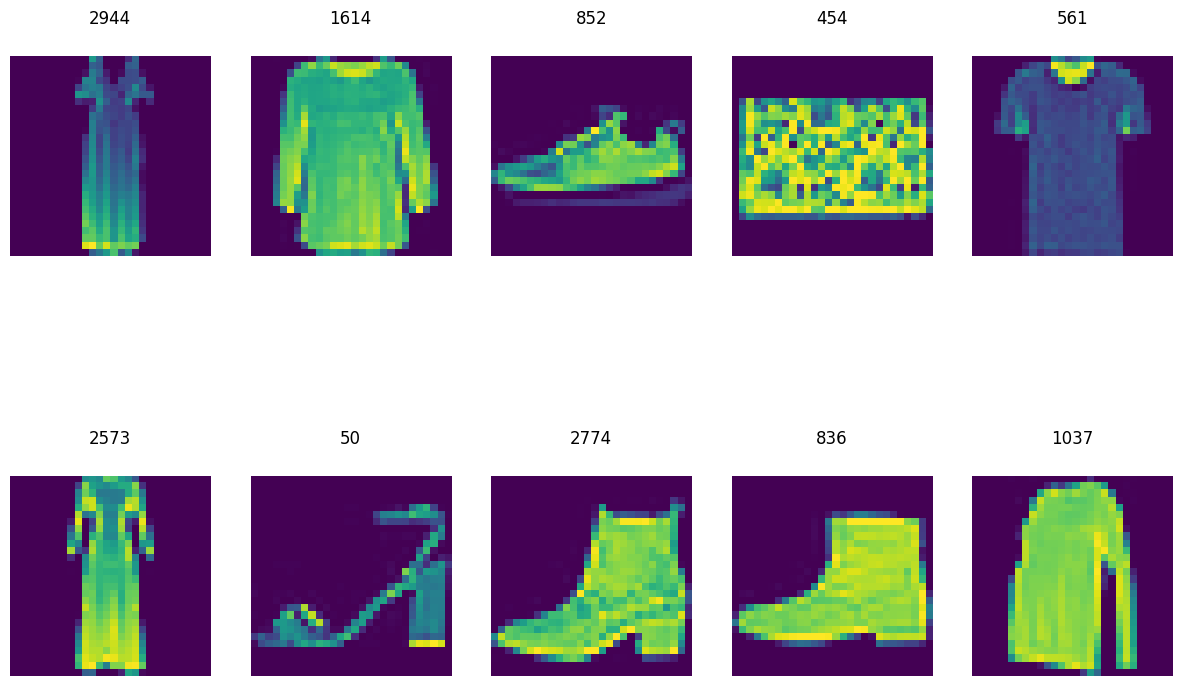

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))

for i in range(10):
    num = np.random.randint(0, 3000)
    j, k = divmod(i, 5)
    axes[j, k].matshow(ximage[num], label = num)
    axes[j, k].axis('off')
    axes[j, k].set_title(num)

plt.show()

1.ii.a: We can see from the plot that we generally have a bias towards seeing clothing, with $6$ out of $10$ being so, and the rest of the articles being split evenly between shoes and bags.

This is likely reflective of the fact that there is a bias in the training data towards class $-1$

1.ii.b:

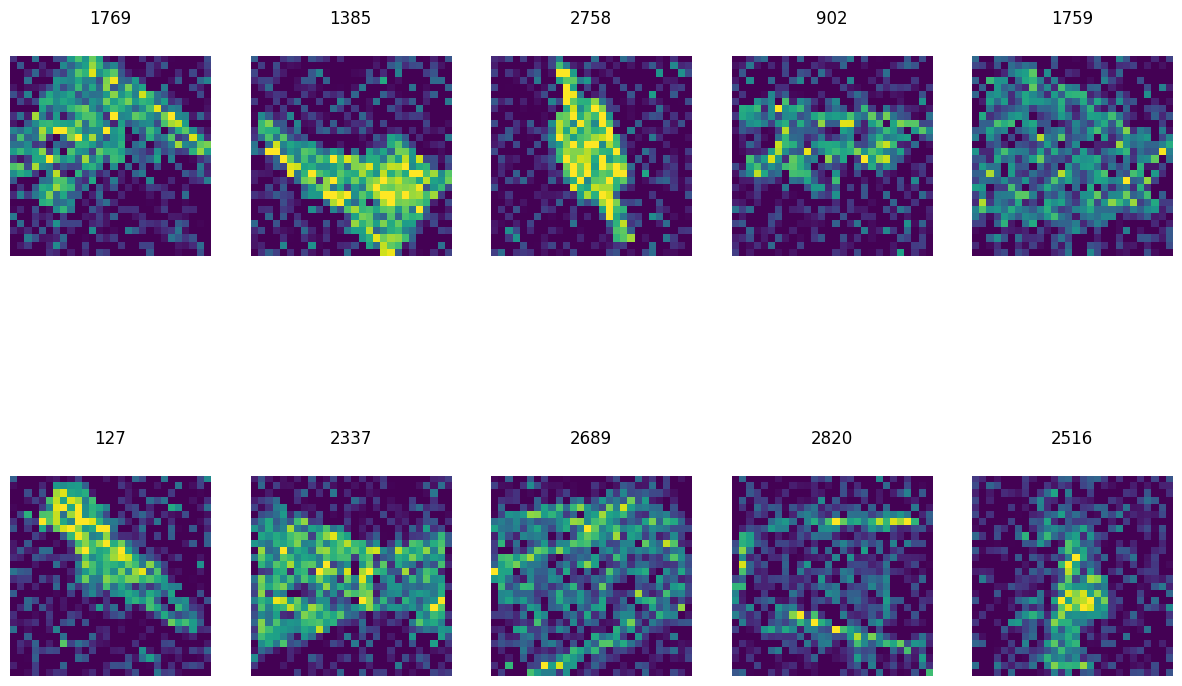

In [5]:
test_img = xtest.reshape(3000, 28, 28)


fig, axes = plt.subplots(2, 5, figsize=(15, 10))

for i in range(10):
    num = np.random.randint(0, 3000)
    j, k = divmod(i, 5)
    axes[j, k].matshow(test_img[num], label = num)
    axes[j, k].axis('off')
    axes[j, k].set_title(num)

plt.show()

The objects in the test set are much more blurry/grainy. This could prove a challenge for the model to classify as none of the images in the training set are similar, so when we generalize and try to analyze the test set we might have a high level of inaccuracy.

1.iii:

AUC-ROC: Area under the reciever operating characteristic curve
$$\\ $$ 
-we plot the true positive rate against the false positive rate to get the ROC curve and then find the area underneath.
$$\\ $$ 
-This works for binary classification when we only have to worry about false positives and false negatives
$$\\ $$ 

-Measures how well the model can differentiate between different classes

AUR-PR: Area under precision recall curve
$$\\ $$ 
-we plot the precision against the recall values and find the area under the curve
$$\\ $$ 
-this allows us to see the precision vs recall, which we cannot do with the AUC-ROC
$$\\ $$ 
-allows us to see the model's performance detecting positives

F1 score:
$$\\ $$ 
-calculated as:
$$\frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$
or
$$\frac{\text{True Positives}+\text{True Negatives}}{\text{True Positives}+\text{True Negatives}+\text{False Positives}+\text{False Negatives}}
$$
-this works well for imbalanced datasets as it takes both false positives and false negatives into account

MCC: Matthews correlation coefficient
$$\\ $$ 
-calculated as:
$$\frac{\text{True Positives}\times\text{True Negatives} - \text{False Positives}\times\text{False Negatives}}{\sqrt{(\text{True Positives}+\text{False Positives})(\text{True Positives}+\text{False Negatives})(\text{True Negatives} +\text{False Positives})(\text{True Negatives}+\text{False Negatives})}}
$$
-this works best for imbalanced datasets as it does not favour the biased class
-ranges from $(-1,1)$ where $-1$ is total misclassification, $0$ is random predictions, and $1$ is perfect 

MSE: Mean squared error
-this calculates the square difference between predictions and their actual classes:

$$\text{MSE} = \frac{1}{N}\sum_{i=1}^N (\hat{x}_i - x_i)^2
$$
where $\hat{x}_i$ is the predicted probability we obseve the positive class and $x_i$ is the actual label, either $0$ or $1$.
-we can use this for probabilistic outputs such as predicting confidence
-the squared terms weight small deviations so we can see their effect more clearly than a normal mean error calculation.

Since we have an imbalanced dataset, we should use MCC, F1-score or AUC-PR as they all don't favour either class and therefore remain accurate. Using a number of different tests allows us to consider different performance metrics such as precision and recall.

The most unsuitable is MSE as it is designed to work best with regression, not classification.

Q2:

2.i:

Implement the SKLearn K-nearest-neighbour classifier:

In [6]:
sknn = KNeighborsClassifier(n_neighbors=5)

sknn.fit(xtrain, ytrain)

KNeighborsClassifier()

Now we calculate the AUC-ROC, AUC-PR, F1 and MCC for each fold:

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

accuracy = []
balanced_acc = []
auc_roc = []
auc_pr  = []
f1 = []
mcc = []


for i, j in kf.split(xtrain, ytrain):
    X_fold, X_val_fold = xtrain[i], xtrain[j]
    y_fold, y_val_fold = ytrain[i], ytrain[j]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_fold, y_fold)
    
    y_pred = knn.predict(X_val_fold)
    y_proba = knn.predict_proba(X_val_fold)[:, 1]
    
    accuracy.append(accuracy_score(y_val_fold, y_pred))
    balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    auc_roc.append(roc_auc_score(y_val_fold, y_proba))
    auc_pr.append(average_precision_score(y_val_fold, y_proba))
    f1.append(f1_score(y_val_fold, y_pred))
    mcc.append(matthews_corrcoef(y_val_fold, y_pred))

I chose (random_ state $= 0$) in the StratifiedKFold() function for reproducibility

Create the table of means and standard deviations:

In [8]:
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'AUC-ROC', 'AUC-PR', 'F1 Score', 'MCC'],
    'Mean': [
        np.mean(accuracy),
        np.mean(balanced_acc),
        np.mean(auc_roc),
        np.mean(auc_pr),
        np.mean(f1),
        np.mean(mcc)
    ],
    'Standard Deviation': [
        np.std(accuracy),
        np.std(balanced_acc),
        np.std(auc_roc),
        np.std(auc_pr),
        np.std(f1),
        np.std(mcc)
    ]
})

print(results_df)

              Metric      Mean  Standard Deviation
0           Accuracy  0.962667            0.007424
1  Balanced Accuracy  0.939062            0.019375
2            AUC-ROC  0.976309            0.008707
3             AUC-PR  0.936674            0.021965
4           F1 Score  0.907558            0.019767
5                MCC  0.884900            0.023706


2.ii:

In [40]:
fpr, tpr, _ = roc_curve(y_val_fold, y_proba)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc[-1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.title('receiver operating characteristic curve')

plt.legend()
plt.show()


IndexError: invalid index to scalar variable.

-The model has AUC-ROC $ = 0.98$, which is very high and tells us that the model is very good at distinguishing between positive and negative classes.

-The true positive rate must also be high (and therefore the false positive rate must be low) because the curve is close to the top left corner, as the left side of the ROC curve represents the false positive region, and less space between the y-axis and the curve means that the false positive rate is also low.

-A low FPR is important in medical diagnoses, fraud detection and cybersecurity, as they can lead to wasted resources/time and in the case of medical diagnoses, can impact the patient's health.


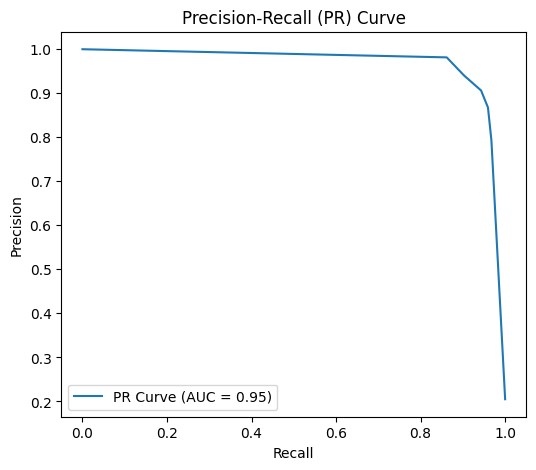

In [ ]:
precision, recall, _ = precision_recall_curve(y_val_fold, y_proba)

plt.plot(recall, precision, label=f'PR curve (AUC = {auc_pr[-1]:.2f})')

plt.xlabel('recall')
plt.ylabel('precision')

plt.title('precision-recall curve')

plt.legend()
plt.show()

-The AUC-PR $=0.95$, which tells us that the classifier has high precision when the recall increases, so the model should work well for unbalanced datasets (like we are dealing with here).

-The top part of the curve being flat tells us that precision remains high and doesn't tail off a lot even for high recall, meaning that the false positive rate is low (like we found from the ROC curve).

-The perfect classifier would have a completely flat line at $\text{precision} = 1$ from $\text{recall} = 0$ to $1$, so our model gets very close to this ideal.

Q3:

i:

To select the optimal classifier, we must implement a version of each type (random forest and SVM with linear, polynomial & RBF kernels) and then analyze their performance to see which is best:

1: we apply feature scaling for the SVM models using sklearn.preprocessing.StandardScaler(), and leave the random forest classifier unscaled.

-This is because random forest is not sensitive to feature scaling in the same way that SVM models are. Decision trees are split based on the ordering of values, so changing the scaling of values won't affect the splits. 

-Leaving RF unscaled also won't affect the fairness of the comparison as we are tuning both models to their optimal hyperparameters and cross-validation is applied equally to both models.

2: To find the optimal hyperparameters, we can use sklearn.model_selection.GridSearchCV().

-We can use this to find the optimal (C, kernel, degree, gamma) for SVM, and the optimal (n_estimators, max_depth, min_samples_split) for RF.

-For SVM, tuning (C, kernel, degree, gamma) allows for a reduction in overfitting and therefore better generalization (at the expense of more misclassifications). Choosing the optimal kernel allows us to reduce computational complexity when having a more costly method doesn't provide us with significant accuracy increases. In the same way, the degree can lead to overfitting if it is too high, but can also lead to a more flexible model. Gamma can also be tuned to capture fine details without increasing the variance too much.

-For RF, n_estimators gives the number of trees, increasing the number of them reduces the variance but also increases the computational cost. Having a larger max_depth also allows the RF tree to capture more patterns/detail, but risks overfitting, reducing the model's ability to generalize. The minimum number of samples per split (min_samples_split) can also be tuned to prevent overfitting by not allowing trees to grow extremely deep and instead having more samples per tree.

3. Next, we use 5-fold stratified cross-validatin to ensure balanced class representation.

-Using stratified cross-validation means that if we are working with an imbalanced dataset, each fold will still have the same class distribution as the original dataset, which means that we don't have to worry about the model being biased towards the majority class.

-This is important for calculating AUC-ROC and AUC-PR, as if the class distribution varies a lot across folds, the curves can vary a lot, leading to a highly varied range of performance metrics which can be hard to interpret.

4. Now we have performed the cross-validation, we can calculate performance metrics such as AUC-ROC & AUC-PR curves, accuracy, balanced accuracy, F1 score and MCC.

5. The optimal classifier will be the one with the highest AUC-ROC, AUC-PR etc. We can also analyze the curves to see which approach the optimal ones.

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
results = {}
roc_curves = {}
pr_curves = {}

svm_kernels = ['linear', 'poly', 'rbf']
svm_models = {}
svm_params = {}

scaler = StandardScaler()
X_scaled = scaler.fit_transform(xtrain)

for kernel in svm_kernels:
    step_name = f'svm-{kernel}'
    svm_models[kernel] = Pipeline([(step_name, SVC(kernel=kernel, probability=True))])
    svm_params[kernel] = {
        f'{step_name}__C': [0.1, 1, 10]
    }
    if kernel == 'poly':
        svm_params[kernel][f'{step_name}__degree'] = [2, 3, 4]
    if kernel in ['poly', 'rbf']:
        svm_params[kernel][f'{step_name}__gamma'] = ['scale', 'auto']

rf_model = Pipeline([('rf', RandomForestClassifier())])
rf_params = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

models = {**svm_models, 'RandomForest': rf_model}
params = {**svm_params, 'RandomForest': rf_params}


for name, model in models.items():
    grid_search = GridSearchCV(model, params.get(name, {}), cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_scaled, ytrain)
    
    best_model = grid_search.best_estimator_
    
    acc_scores = []
    bal_acc_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    
    for train_idx, test_idx in cv.split(X_scaled, ytrain):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = ytrain[train_idx], ytrain[test_idx]
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        acc_scores.append(accuracy_score(y_test, y_pred))
        bal_acc_scores.append(balanced_accuracy_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_proba))
        pr_auc_scores.append(average_precision_score(y_test, y_proba))
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        
        roc_curves.setdefault(name, []).append((fpr, tpr))
        pr_curves.setdefault(name, []).append((precision, recall))
    
    results[name] = {
        'accuracy': (np.mean(acc_scores), np.std(acc_scores)),
        'balanced accuracy': (np.mean(bal_acc_scores), np.std(bal_acc_scores)),
        'AUC-ROC': (np.mean(roc_auc_scores), np.std(roc_auc_scores)),
        'AUC-PR': (np.mean(pr_auc_scores), np.std(pr_auc_scores))
    }

summary_df = pd.DataFrame.from_dict(results, orient='index',
                                    columns=['accuracy', 'balanced accuracy', 'AUC-ROC', 'AUC-PR'])
print(summary_df)

                                                Accuracy  \
linear                      (0.95, 0.007527726527090808)   
poly                      (0.967, 0.0024494897427831744)   
rbf            (0.9710000000000001, 0.00442216638714053)   
RandomForest  (0.9700000000000001, 0.008755950357709132)   

                                       Balanced Accuracy  \
linear           (0.92500581988725, 0.01545404474953014)   
poly            (0.9369395324069962, 0.0120490852217451)   
rbf           (0.9563774341144657, 0.012438972203468578)   
RandomForest   (0.9442637081637437, 0.02170173486884178)   

                                                  AUC-ROC  \
linear         (0.9822675543111645, 0.003984530063704685)   
poly           (0.991603008513415, 0.0021794808561190343)   
rbf            (0.9926393701939297, 0.002435729328675625)   
RandomForest  (0.9916152215522891, 0.0028859394326678288)   

                                                   AUC-PR  
linear         (0.93404364927146

Print optimized hyperparameters:

In [12]:
best_hyperparams = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, params.get(name, {}), cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_scaled, ytrain)
    
    best_hyperparams[name] = grid_search.best_params_

for model_name, hyperparams in best_hyperparams.items():
    print(f"\nBest Hyperparameters for {model_name}:")
    for param, value in hyperparams.items():
        print(f"{param}: {value}")


Best Hyperparameters for linear:
svm-linear__C: 0.1

Best Hyperparameters for poly:
svm-poly__C: 10
svm-poly__degree: 3
svm-poly__gamma: scale

Best Hyperparameters for rbf:
svm-rbf__C: 10
svm-rbf__gamma: auto

Best Hyperparameters for RandomForest:
rf__max_depth: None
rf__min_samples_leaf: 1
rf__min_samples_split: 2
rf__n_estimators: 100


Plot AUC-ROC curves:

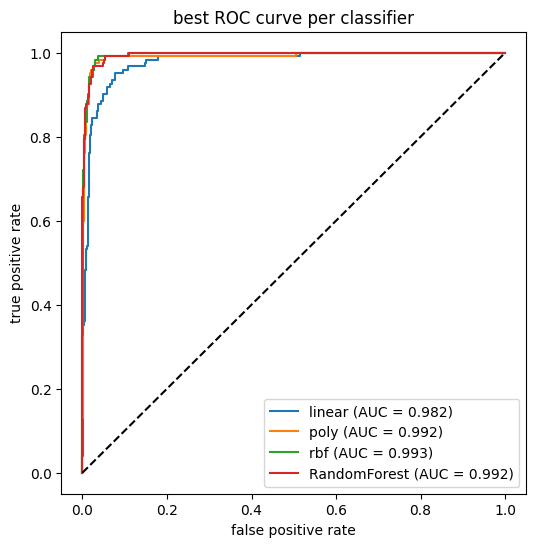

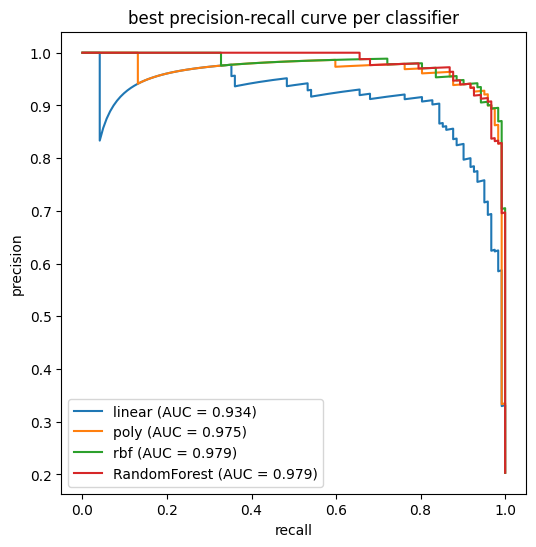

In [13]:
plt.figure(figsize = (6, 6))
for name in roc_curves.keys():
    fpr, tpr = roc_curves[name][0]
    auc_roc = results[name]['AUC-ROC'][0]
    plt.plot(fpr, tpr, label = f"{name} (AUC = {auc_roc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.title("best ROC curve per classifier")

plt.legend()
plt.show()

plt.figure(figsize = (6, 6))
for name in pr_curves.keys():
    precision, recall = pr_curves[name][0]
    auc_pr = results[name]['AUC-PR'][0]
    plt.plot(recall, precision, label = f"{name} (AUC = {auc_pr:.3f})")

plt.xlabel("recall")
plt.ylabel("precision")

plt.title("best precision-recall curve per classifier")

plt.legend()
plt.show()

ROC curve:

-All of the models have AUC-ROC values $> 0.98$ which is very high, indicating that they can differentiate between classes very well.

-The RBF SVM kernel has the highest AUC-ROC, indicating that it is the best at classifying between positive and negative classes. The linear SVM kernel has the lowest score, however this is expected as it is the least complex model and can struggle to capture some of the fine detail in the data compared to RBF and polynomial kernels, which are more complex (but can sometimes lead to overfitting).

-Because the curves are all close to the top left corner, they are close to the ideal AUC-ROC line (which is a straight line between $x=[0, 1]$).


PR curve:

-The RBF kernel and RF both have the highest AUC-PR scores, showing that they keep high precision as recall increases. 

-The linear SVM kernel has a greater drop-off and dips more at the beginning, indicating that it struggles to maintain high precision for some recall thresholds. This could be because the data has some non-linear relationships that the linear kernel struggles to capture, or because the initial preditions are incorrect.

-The polynomial SVM kernel also has a high AUC-PR score and has little drop off, remaining broadly in line with RBF SVM and RF, but has a slightly lower score due to a dip around recall $= 0.2$. This means that for the first few predictions with high-confidence, the precision is lower than expected.


The RBF SVM kernel is the best choice as it has the highest AUC-ROC and AUC-PR scores. However, RF may be better for some applications as it provides almost the same accuracy but can be faster for large datasets due to a lower computational complexity ($\mathcal{O}(n \log n)$ vs $\mathcal{O}(n^2)$ to $\mathcal{O}(n^3)$ for RBF) and a more easily parallelizable algorithm.

Q4:

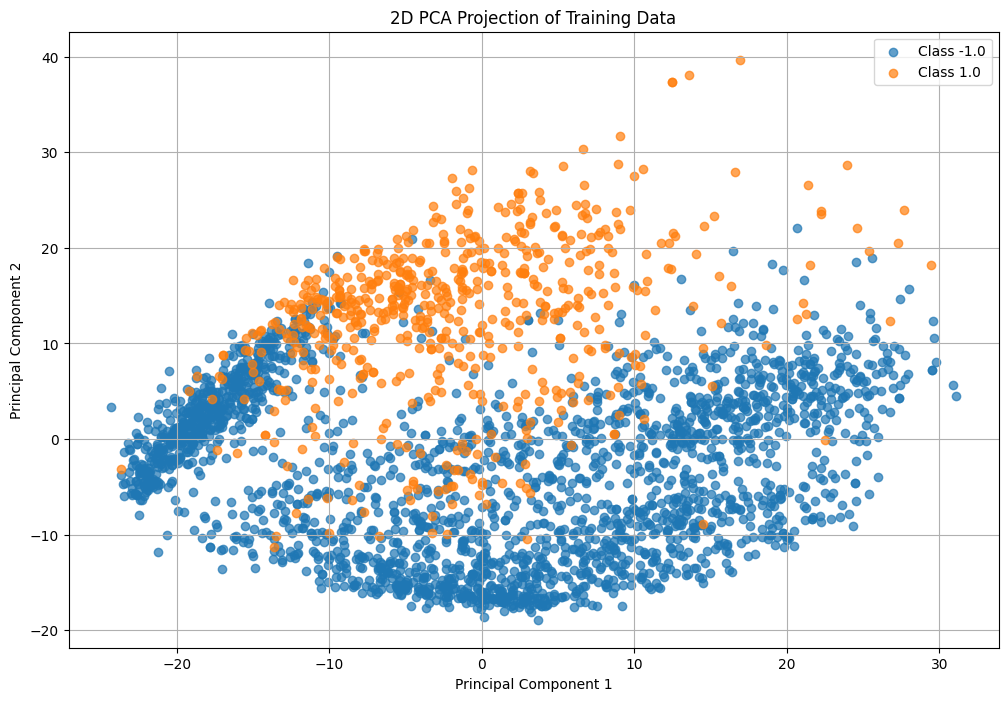

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for label in np.unique(ytrain):
    plt.scatter(X_pca[ytrain == label, 0], X_pca[ytrain == label, 1], label=f'Class {label}', alpha=0.7)

plt.title('2D PCA Projection of Training Data')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend()
plt.grid()
plt.show()

-The two classes show separation over PC1, and none over PC2 (class 1 is completely embedded within class -1 over PC2).

-There is a lot of overlap still of both classes over PC1, so a linear boundary may not be sufficiently accurate. This explains why linear SVM works less well than RBF/polynomial SVM and RF.

-The spread of data along PC1 is also greater, so it must represent a component of the data with higher variance. PC2 also has a significant portion of the variance but less than PC1.

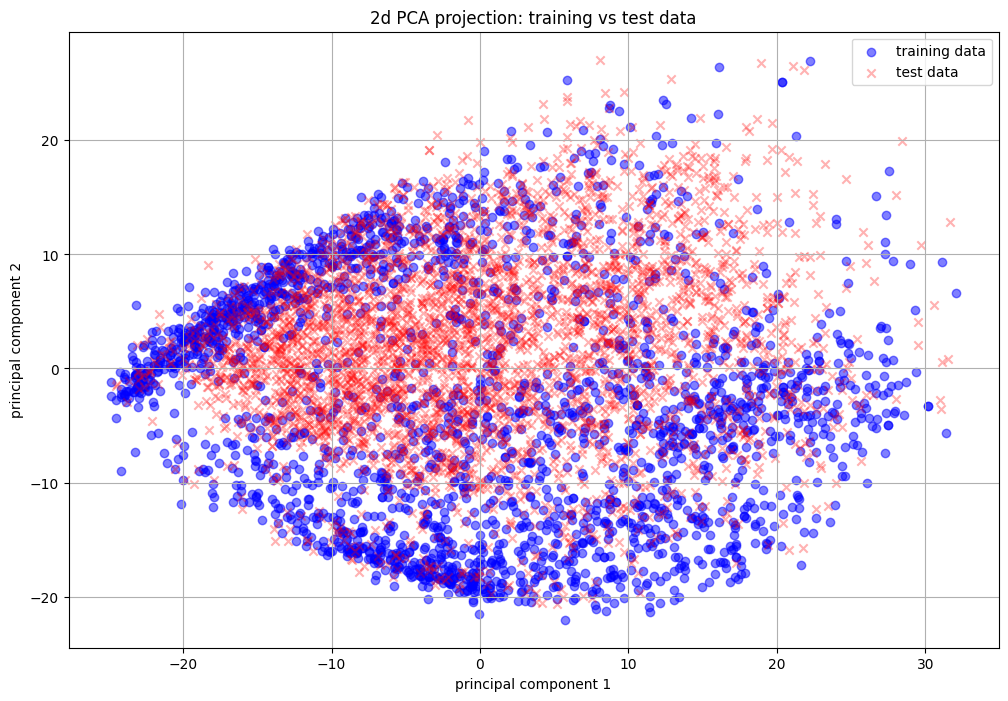

In [ ]:
X_combined = np.vstack((xtrain, xtest))
y_combined = np.hstack((ytrain, y_test))

scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

X_pca_combined = pca.fit_transform(X_combined_scaled)

X_pca_train = X_pca_combined[: len(X_train)]
X_pca_test = X_pca_combined[len(X_train) :]

plt.figure(figsize=(12, 8))
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], color = "blue", label = "training data", alpha = 0.5, marker = "o")
plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], color = "red", label = "test data", alpha = 0.3, marker = "x")

plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

plt.title("2d PCA projection: training vs test data")

plt.legend()
plt.grid()
plt.show()


We can compare the distribution of training vs test data with the 2D PCA of the training data to see the model's ability to classify.

-The training and test data cover roughly the same area, which tells us that the test data is represented well in the training data.

-In the upper right region there is less dense grouping, which could be due to some outliers being present.

-The shape of the $2^{nd}$ plot is roughly the same as the $1^{st}$, indicating that the PCA captures a lot of the variance in the data, but since the classes are still overlapping in places, it could be useful to take a transformation such as t-SNE to more effectively analyze the data distribution.

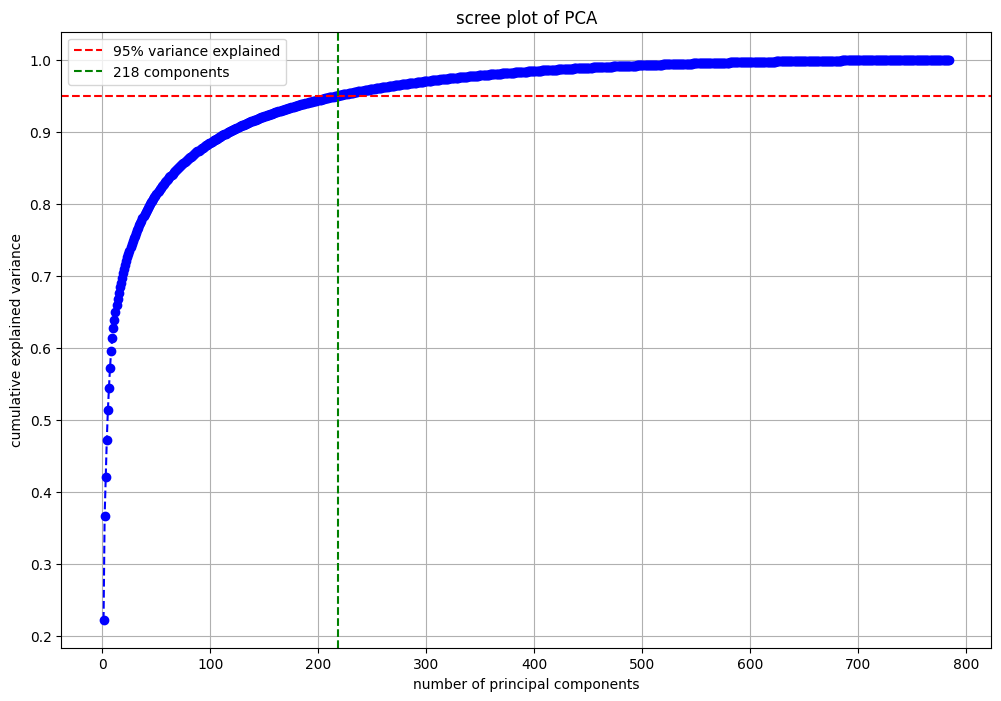

number of principal components explaining 95% variance: 218


In [16]:
pca = PCA()
pca.fit(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_95 = np.argmax(explained_variance >= 0.95) + 1 

plt.figure(figsize = (12, 8))

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = 'o', linestyle = '--', color = 'blue')

plt.axhline(y = 0.95, color = 'red', linestyle = '--', label = "95% variance explained")
plt.axvline(x = n_components_95, color = 'g', linestyle = '--', label = f"{n_components_95} components")

plt.xlabel("number of principal components")
plt.ylabel("cumulative explained variance")

plt.title("scree plot of PCA")

plt.legend()
plt.grid()
plt.show()

print(f"number of principal components explaining 95% variance: {n_components_95}")


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

n_pca_components = X_train_pca.shape[1]
print(f"number of selected PCA components: {n_pca_components}")

svm_pipeline = Pipeline([
    ('pca', PCA(n_components = n_pca_components)),
    ('svm', SVC(kernel = 'rbf', probability = True))
])

param_grid = {
    'pca__n_components': [n_pca_components - 5, n_pca_components, n_pca_components + 5],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
grid_search = GridSearchCV(svm_pipeline, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"best parameters: {best_params}")
print(f"test accuracy: {accuracy:.4f}")
print(f"balanced accuracy: {balanced_accuracy:.4f}")
print(f"test AUC-ROC: {roc_auc:.4f}")


Number of selected PCA components: 210
Best Parameters: {'pca__n_components': 215, 'svm__C': 1, 'svm__gamma': 'scale'}
Test Accuracy: 0.9717
Balanced Accuracy: 0.9580
Test AUC-ROC: 0.9933


Q5:

In [19]:
#I redefined xtrain, xtest, ytrain to keep their original forms stored.
X_train = xtrain
Y_train = ytrain
X_test = xtest

image_size = 28
X_train = X_train.reshape(-1, image_size, image_size, 1) / 255.0
X_test = X_test.reshape(-1, image_size, image_size, 1) / 255.0

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 2)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape = (image_size, image_size, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

model.compile(optimizer = Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
hist = model.fit(X_train, Y_train, validation_split = 0.2, epochs = 20, batch_size = 32, callbacks = [early_stopping])

predictions = model.predict(X_test)[:, 1]

submission = pd.DataFrame(predictions, columns = ['Prediction'])
submission.to_csv('your_student_id.csv', index = False)

C:\Users\jaisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9838 - loss: 0.0363 - val_accuracy: 0.0000e+00 - val_loss: 3.7545
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.3232e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.8594
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.7372e-06 - val_accuracy: 0.0000e+00 - val_loss: 7.5944
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.1041e-07 - val_accuracy: 0.0050 - val_loss: 6.1894
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.8697e-06 - val_accuracy: 0.2167 - val_loss: 3.2928
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 6.9227e-07 - val_accuracy: 0.6533 - val_loss: 0.9821
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.8713e-07 - val_accuracy: 0.9183 - val_loss: 0.1807
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - los

We can now plot our results:

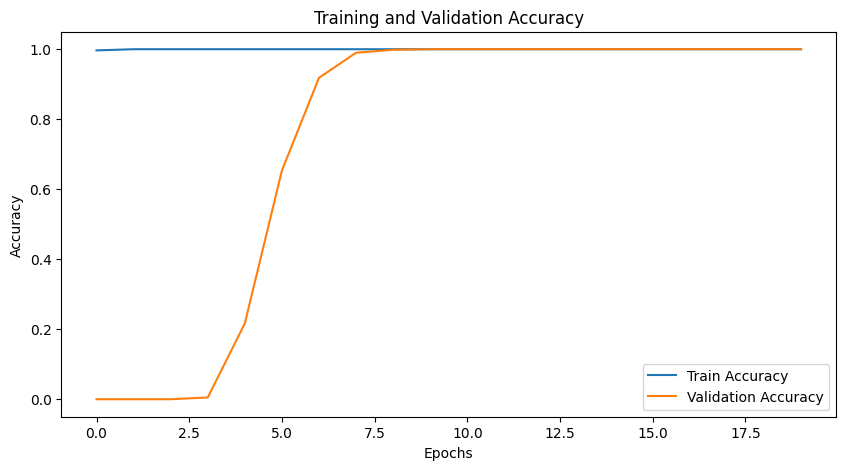

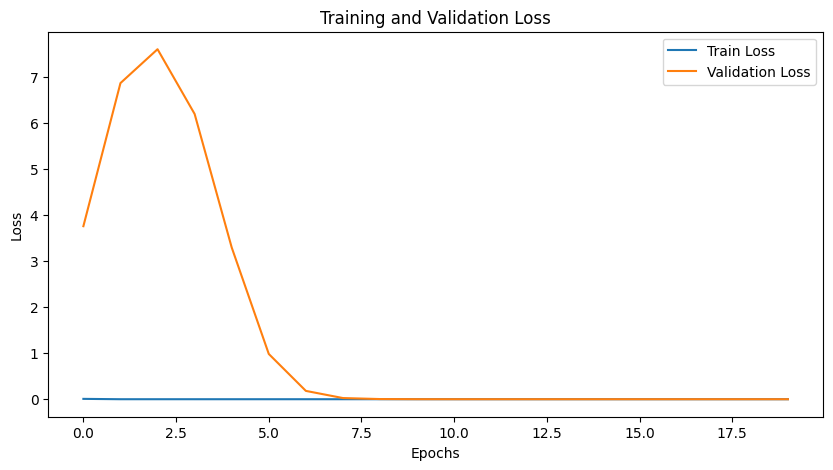

In [ ]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')

plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')

plt.legend()
plt.show()

I implemented a convolutional neural network with 2 convolutional layers that analyze the normalized data (for model stability).

The first convolutional block extracts 32 features and the second block extracts 64. This is because the first layer is used to analyze smoother/basic features such as edges, and the second is used to analyze more complex features such as rougher patterns. This is done to ensure that learning is kept efficient due to the doubling of layer size.

I used tf.keras.losses.CategoricalCrossentropy() as the loss function for multi-class classification, and the Adam optimizer to speed up as we have a large dataset.

For the training, we stop after 5 epochs if we don't see any improvement in loss. This prevents unnecessary computation if the loss doesn't converge.

The trained convolutional neural network is used to predict probabilities of each datapoint being in each class.

The model converges quickly and the training and validation accuracy are almost identical after 20 epochs, indicating that the model performs well and has strong generalization. Also, due to the use of tf.keras.layers.Dropout and tf.keras.layers.BatchNormalization, we do not have any significant overfitting (this is evident from the strong generalization).

Q6:

In [39]:
ytrain_new = np.full(xtrain.shape[0], -1)
ytest_new = np.full(X_test.shape[0], 1)

xcombined = np.vstack((xtrain, xtest))
ycombined = np.concatenate((ytrain_new, ytest_new))

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
auc_scores = cross_val_score(clf, xcombined, ycombined, cv = kf, scoring = 'roc_auc')

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"Mean AUC-ROC: {mean_auc:.4f}")
print(f"Standard Deviation of AUC-ROC: {std_auc:.4f}")

Mean AUC-ROC: 1.0000
Standard Deviation of AUC-ROC: 0.0000


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(xcombined, ycombined, test_size = 0.2, stratify = ycombined, random_state = 0)

clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf.fit(X_train, Y_train)

val_predictions = clf.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(Y_val, val_predictions)

print(f"Validation AUC-ROC: {auc_score:.4f}")


Validation AUC-ROC: 1.0000


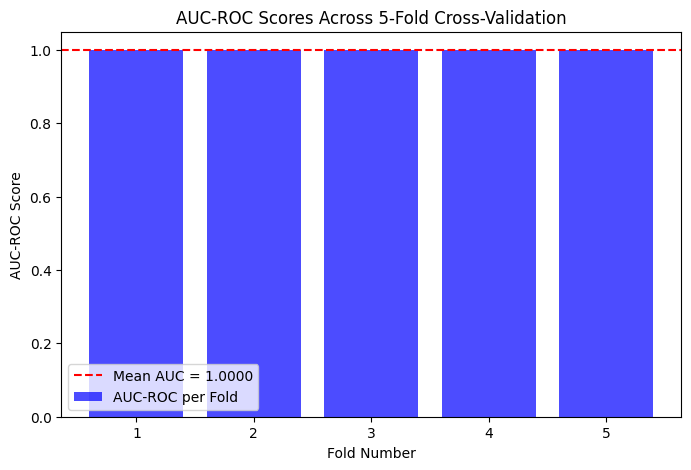

The training and test sets are significantly different. There might be dataset leakage or domain shift.


In [ ]:
plt.figure(figsize=(8, 5))

plt.bar(range(1, 6), auc_scores, color = 'blue', alpha = 0.7, label = 'AUC-ROC per fold')
plt.axhline(mean_auc, color = 'red', linestyle = '--', label = f'Mean AUC = {mean_auc:.4f}')

plt.xlabel('fold number')
plt.ylabel('AUC-ROC score')

plt.title('AUC-ROC scores across 5-fold cross-validation')

plt.legend()
plt.show()


if mean_auc > 0.7:
    print("the training and test sets are significantly different. there might be dataset leakage or domain shift.")
elif mean_auc < 0.6:
    print("the training and test sets are well-matched. no significant differences detected.")
else:
    print("there might be minor differences, but they are not substantial.")

The perfect ROC score tells us that the test and training sets are very similar, so we cannot make any conclusive statements about how well the model generalizes. A well balanced dataset would have an ROC of around 0.5. This also means that the classifier is not learning useful generalization patterns.

To detect and diagnose systematic differences, we can compare the datasets xtrain and xtest directly. This could be made easier by normalizing the values of each dataset. 

We can also look at the feature distributions between training and test sets. By visualizing the distributions, we can see that if they are similar, the model is classifying data that it already knows well. But if the datasets have different distributions, we can say that the model has learned dataset membership well and will therefore generalize well.

We could also look at data characteristics that are strongly correlated with class membership. By removing these, we allow the model to purely focus on more anomalous features.

In [ ]:
ytrain_new = np.full(xtrain.shape[0], -1)
ytest_new = np.full(xtest.shape[0], 1)

xcombined = np.vstack((xtrain, xtest))
ycombined = np.concatenate((ytrain_new, ytest_new))

X_train, X_val, Y_train, Y_val = train_test_split(xcombined, ycombined, test_size = 0.2, stratify = ycombined, random_state = 0)

def noise(data, noise_level = 0.1):
    noise_ = np.random.normal(0, noise_level, data.shape)
    return data + noise_

X_train_noisy = noise(X_train)

def rand_rotation(data, max_angle = 30):
    rotated_data = np.array([sci.ndimage.rotate(sample.reshape(28, 28), angle = np.random.uniform(-max_angle, max_angle), reshape = False).flatten()
                             for sample in data])
    return rotated_data

X_train_aug = rand_rotation(X_train_noisy)

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
auc_scores = cross_val_score(clf, X_train_aug, Y_train, cv = kf, scoring = 'roc_auc')

clf.fit(X_train_aug, Y_train)

val_predictions = clf.predict_proba(X_val)[:, 1]
val_auc_roc = roc_auc_score(Y_val, val_predictions)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"mean cross-validation AUC-ROC: {mean_auc:.4f}")
print(f"standard deviation of AUC-ROC: {std_auc:.4f}")
print(f"validation AUC-ROC: {val_auc_roc:.4f}")


Mean Cross-Validation AUC-ROC: 0.9984
Standard Deviation of AUC-ROC: 0.0010
Validation AUC-ROC: 0.9983


In [ ]:
baseline_auc = cross_val_score(clf, X_train, Y_train, cv = kf, scoring = 'roc_auc')
baseline_auc_mean = np.mean(baseline_auc)
baseline_auc_std = np.std(baseline_auc)

print(f"baseline mean AUC-ROC: {baseline_auc_mean:.4f}")
print(f"baseline standard deviation of AUC-ROC: {baseline_auc_std:.4f}")    

Baseline Mean AUC-ROC: 1.0000
Baseline Standard Deviation of AUC-ROC: 0.0000
